# Training a Rockpool network with Jax

In [1]:
try:
    from rich import print
except:
    pass

## Loss functions

### Loss function components provided by Rockpool

In [2]:
from rockpool.training import jax_loss as l

### Writing your own loss function

In [3]:
import jax.numpy as jnp

def loss_mse(grad_params, net, input, target):
    # - Handle the network state — randomise or reset
    net = net.reset_state()
    
    # - Assign the provided parameters to the network
    net = net.set_attributes(grad_params)
       
    # - Evolve the network to get the ouput
    output, _, _ = net(input)
    
    # - Compute a loss value w.r.t. the target output
    return l.mse(output, target)    

## Defining a task

In [39]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassRandomSinMapping():
    def __init__(self,
                 num_classes: int = 2,
                 sample_length: int = 100,
                 input_channels: int = 50,
                 target_channels: int = 2,
                 *args, **kwargs):
        # - Initialise superclass
        super().__init__(*args, **kwargs)
        
        # - Record parameters
        self._num_classes = num_classes
        self._sample_length = sample_length
        
        # - Draw random inputs
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.
        
        # - Draw random target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        
        # - Generate target outputs
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(2 * np.pi * self._target_omega * time_base + self._target_phase)
    
    def __len__(self):
        return self._num_classes
    
    def __getitem__(self, i):
        return self._inputs[i], self._targets[i]

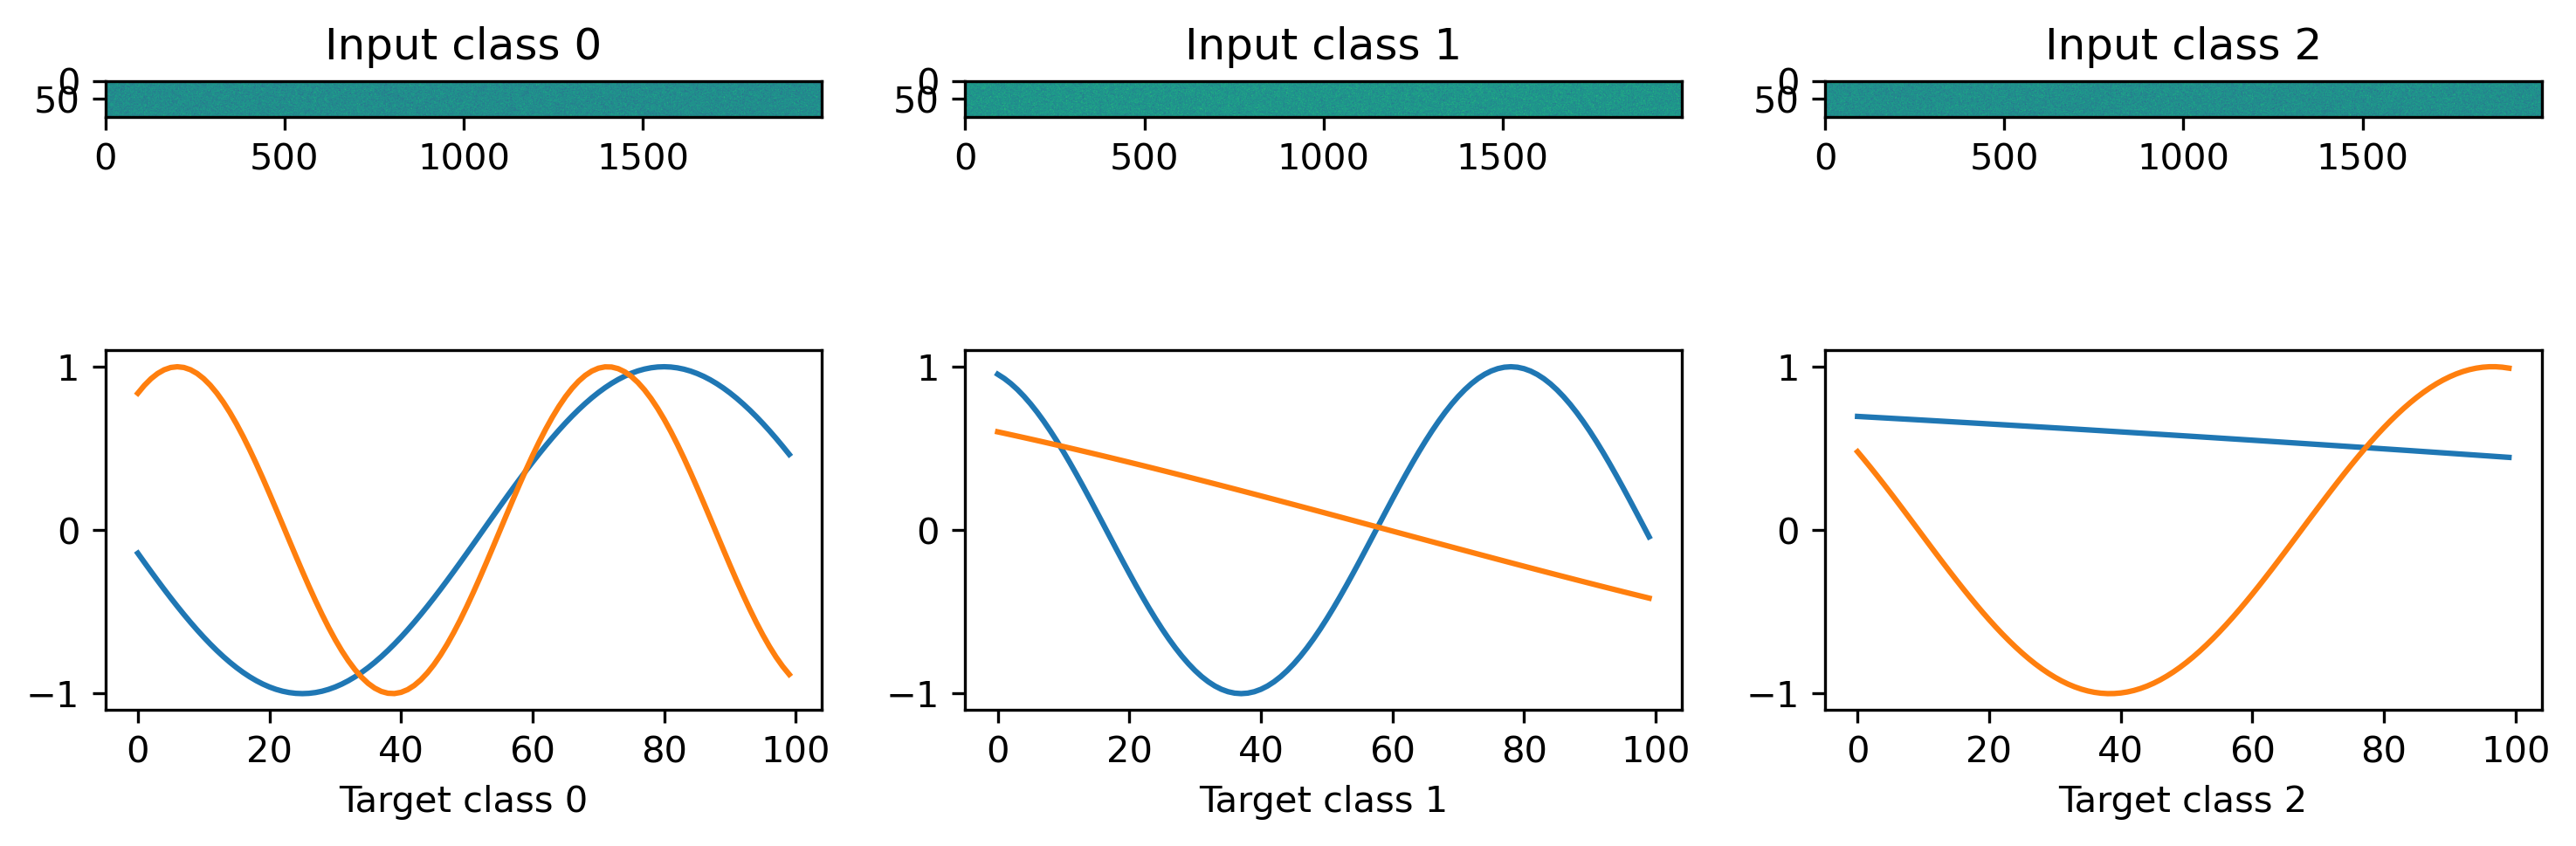

In [96]:
# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 3
T = 100
ds = MultiClassRandomSinMapping(num_classes = num_classes,
                                input_channels = Nin,
                                target_channels = Nout,
                                sample_length = T,
                               )

# Display dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0])
    plt.title(f'Input class {i}')
    
    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f'Target class {i}')

## Building a Jax network

In [97]:
from rockpool.nn.modules import RateEulerJax, LinearJax, InstantJax
from rockpool.nn.combinators import Sequential

import jax.numpy as jnp

Nhidden = 800

net = Sequential(
    LinearJax((Nin, Nhidden)),
    InstantJax(Nhidden, jnp.tanh),
    LinearJax((Nhidden, Nout)),
)
print(net)

## Writing a training loop

In [98]:
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from copy import deepcopy

from itertools import count

# -- Import an optimiser to use and initalise it
import jax
from jax.experimental.optimizers import adam

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-4)

# - Initialise the optimiser with the initial parameters
params0 = deepcopy(net.parameters())
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 100

# - Loop over iterations
i_trial = count()
for _ in tqdm(range(num_epochs)):
    for sample in ds:
        # - Get an input / target sample
        input, target = sample[0], sample[1]
        
        # - Get parameters for this iteration
        params = get_params(opt_state)

        # - Get the loss value and gradients for this iteration
        loss_val, grads = loss_vgf(params, net, input, target)

        # - Update the optimiser
        opt_state = update_fun(next(i_trial), grads, opt_state)
        
        # - Keep track of the loss
        loss_t.append(loss_val)

  0%|          | 0/100 [00:00<?, ?it/s]

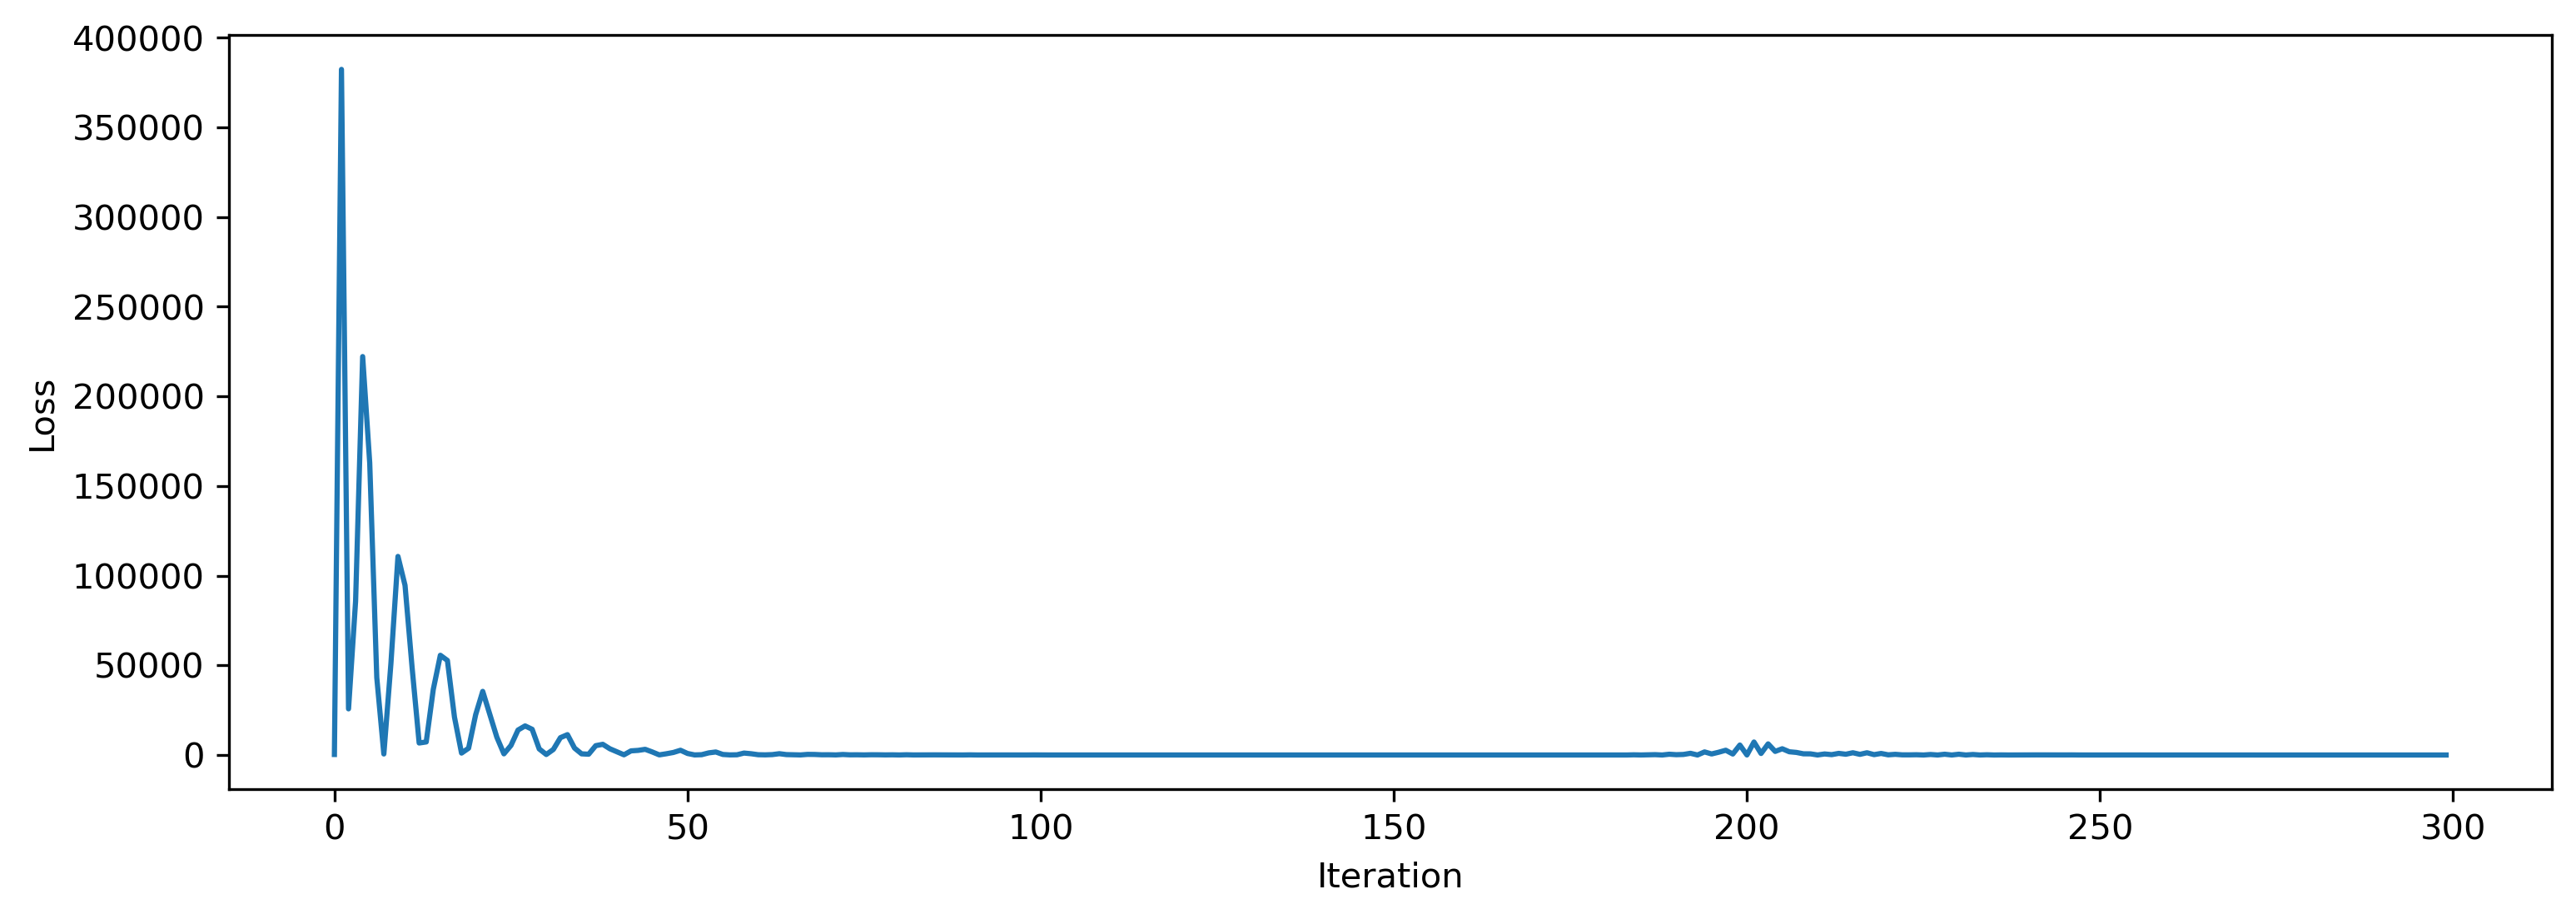

In [99]:
# - Plot the loss over iterations
plt.plot(loss_t)
plt.xlabel('Iteration')
plt.ylabel('Loss');

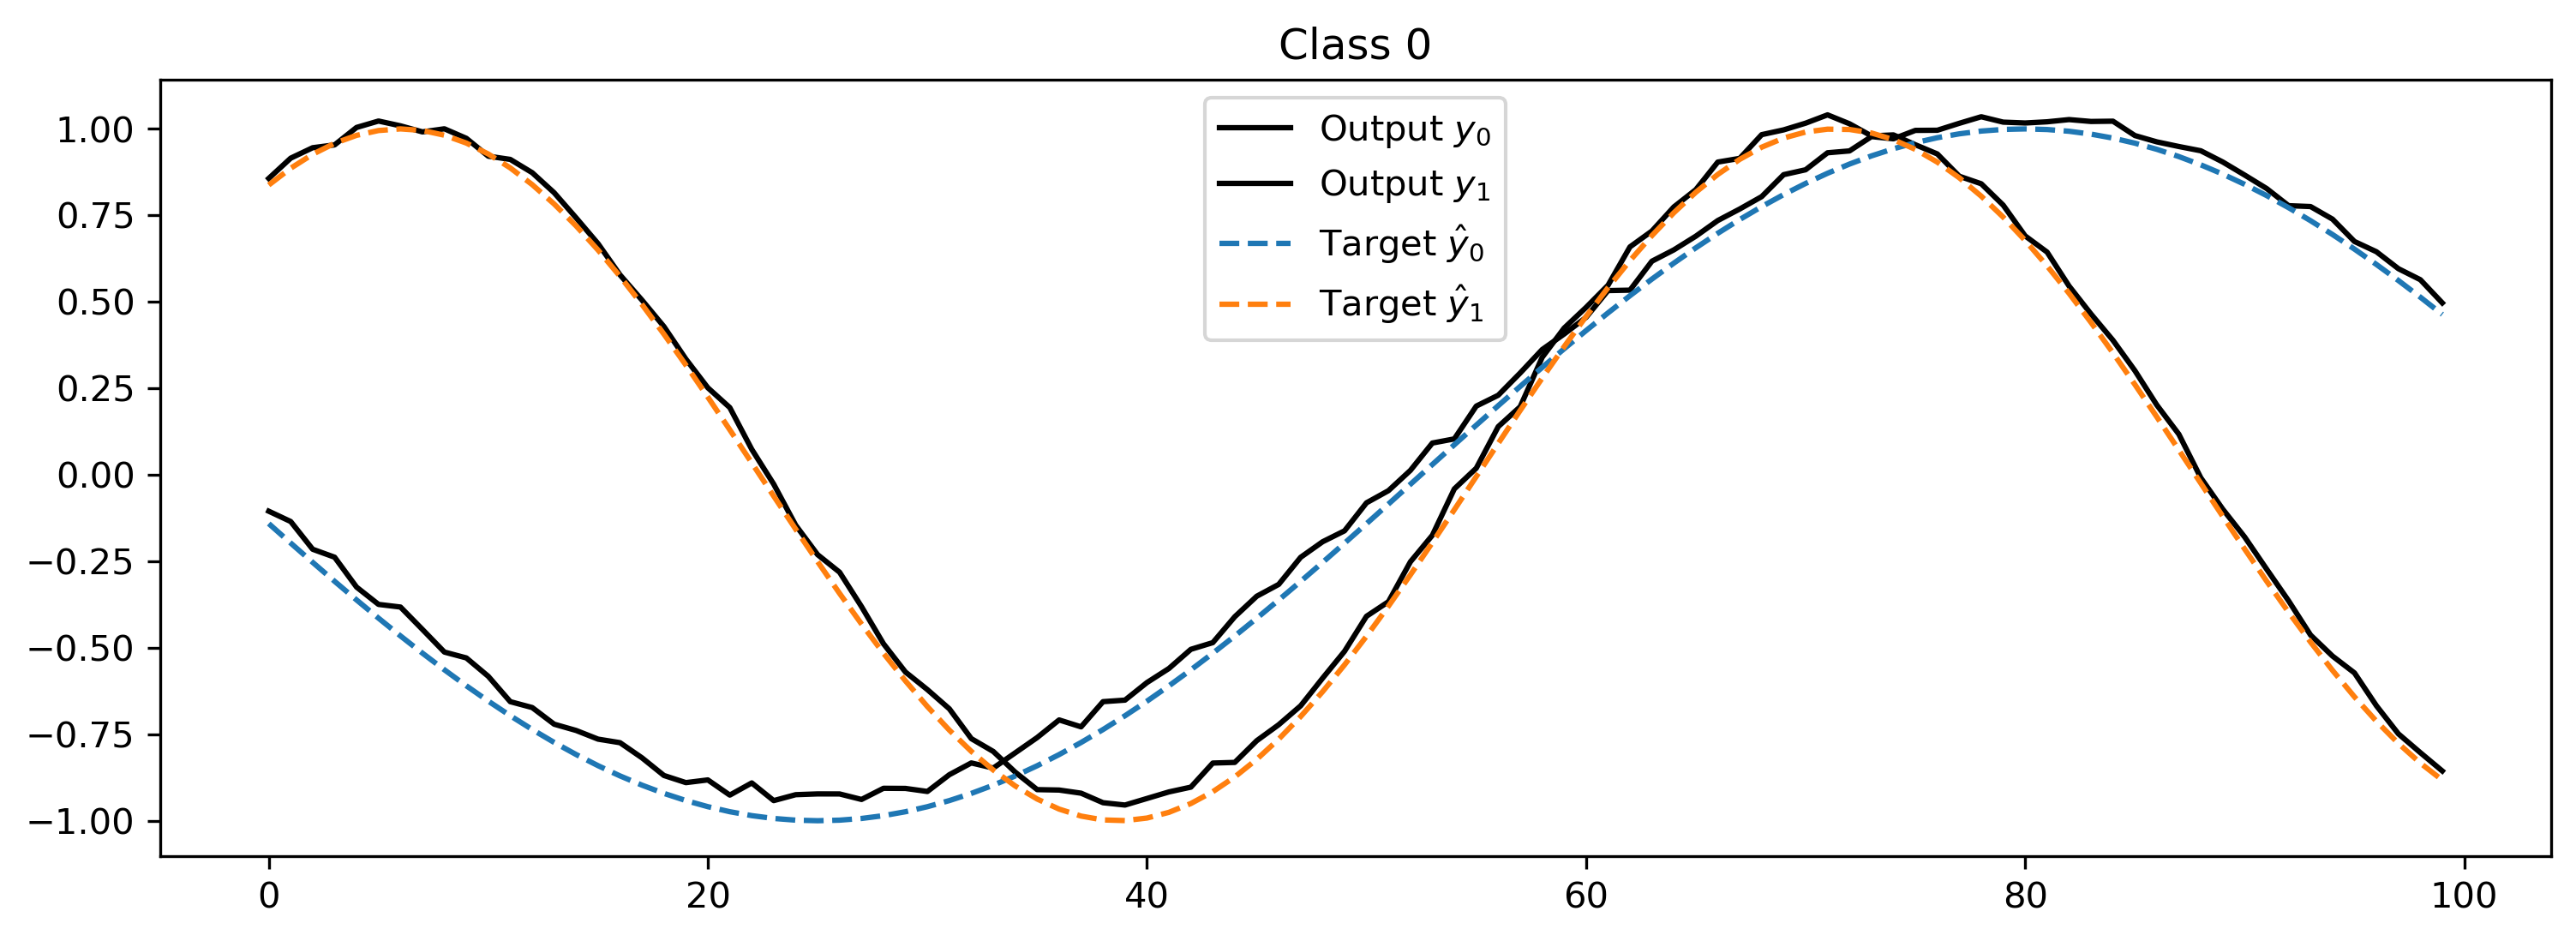

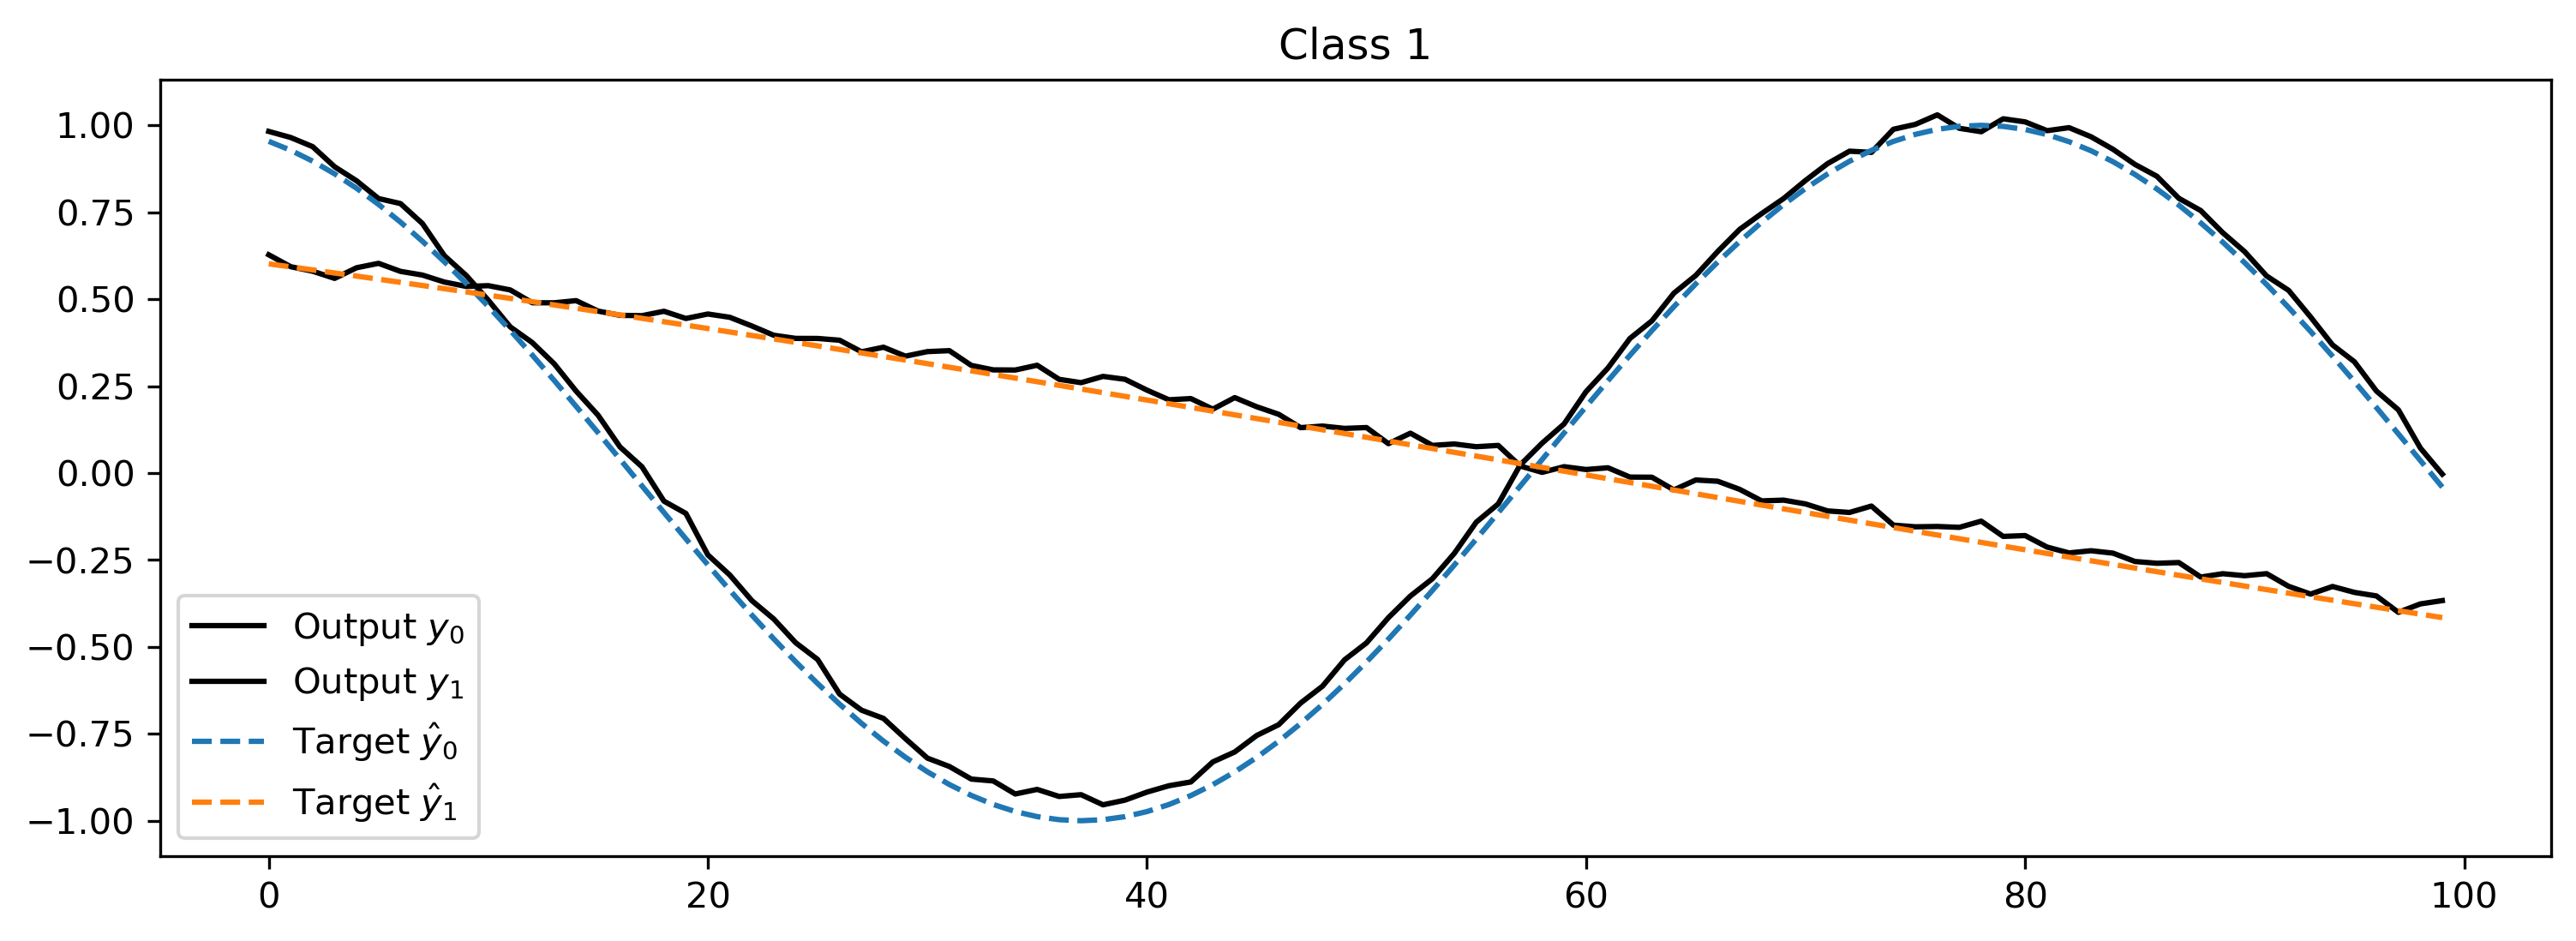

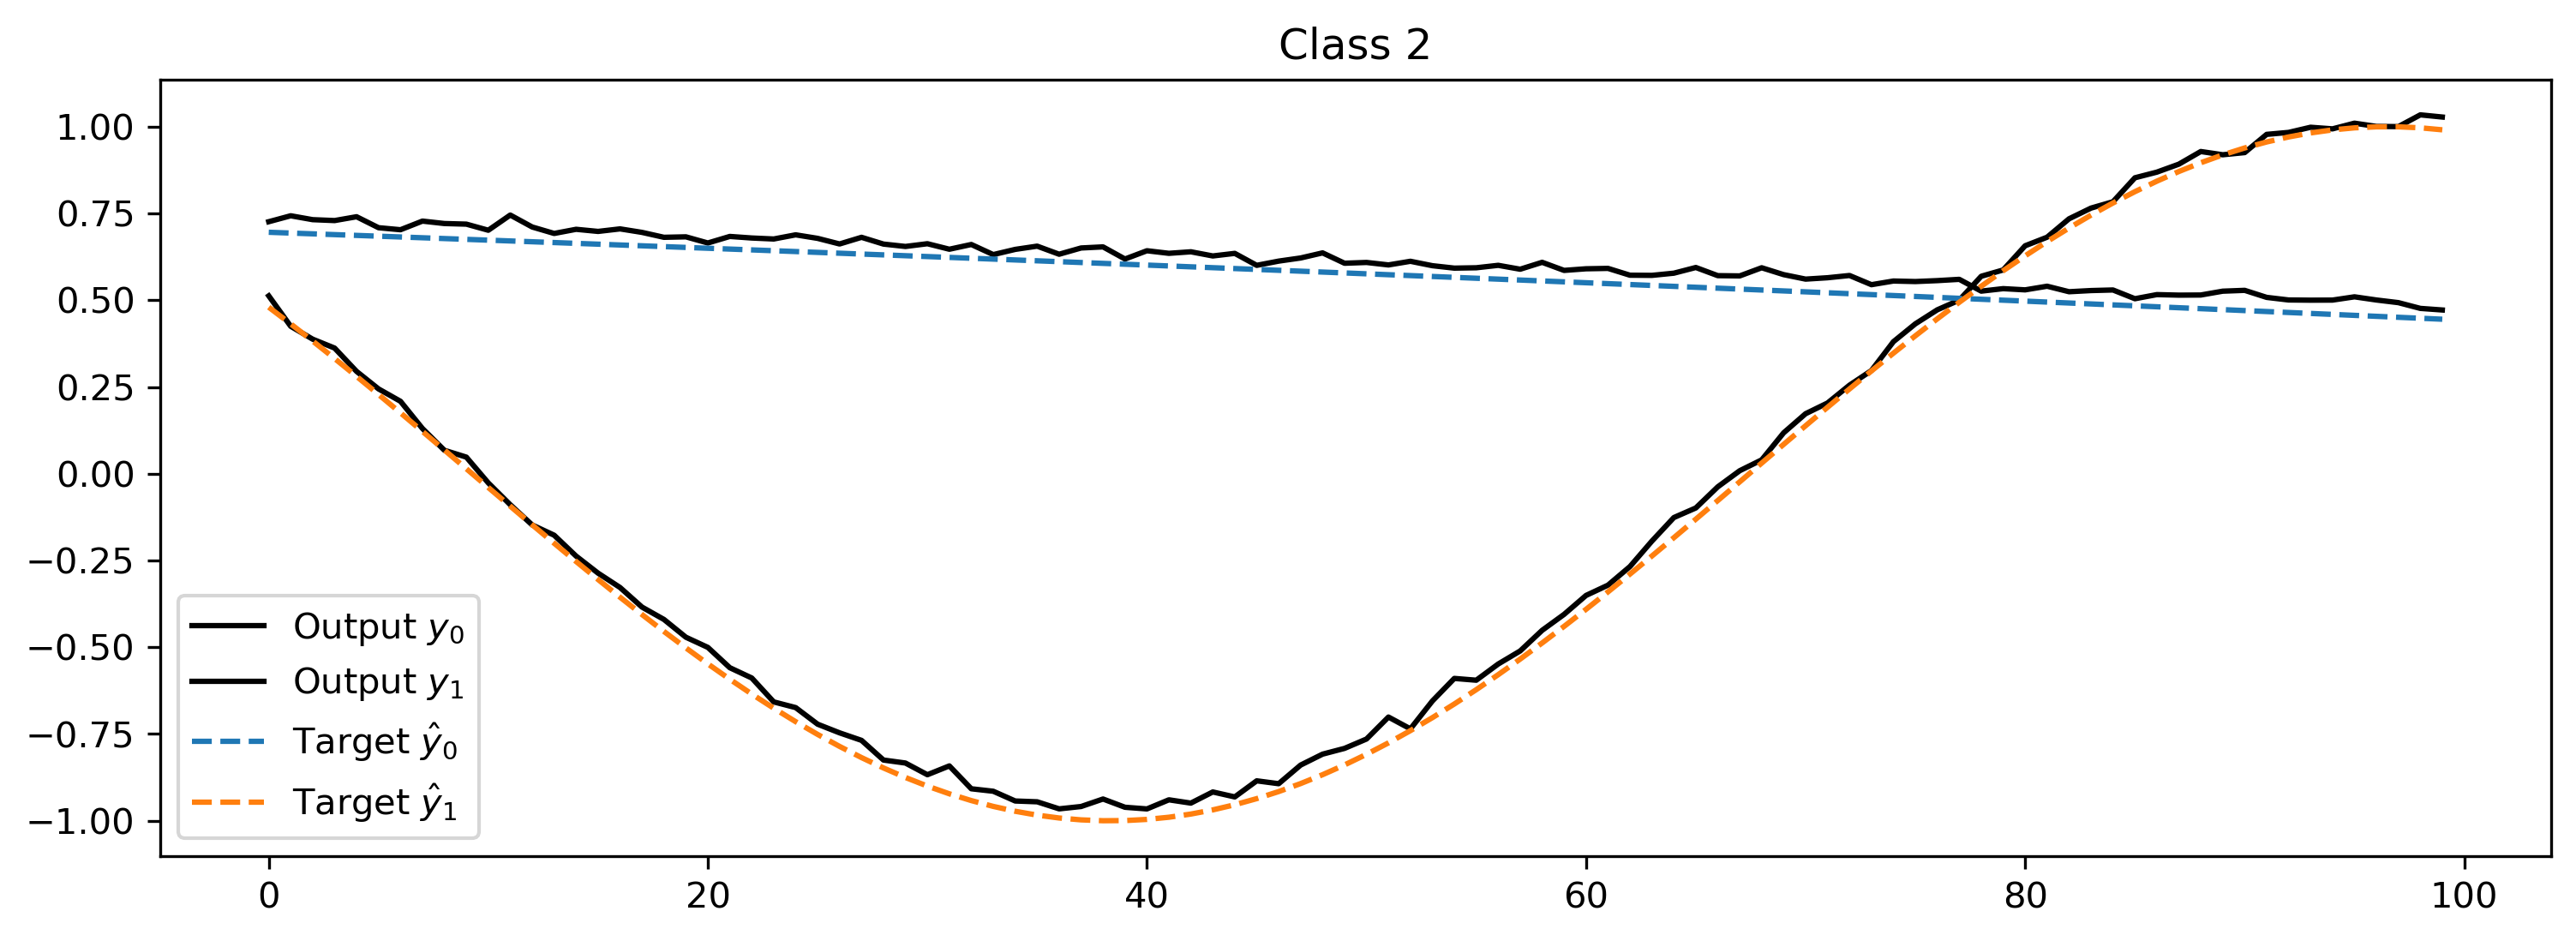

In [100]:
# Apply parameters
params = deepcopy(get_params(opt_state))
net = net.set_attributes(params)

# - Evaluate classes
for i_class, sample in enumerate(ds):
    input, target = sample

    # - Evaluate network
    net = net.reset_state()
    output, _, _ = net(input, record = True)
    
    # - Plot output and target
    plt.figure()
    plt.plot(output, 'k-')
    plt.plot(sample[1], '--')
    plt.legend(['Output $y_0$',
                'Output $y_1$',
                'Target $\hat{y}_0$',
                'Target $\hat{y}_1$',
               ])
    plt.title(f'Class {i_class}')

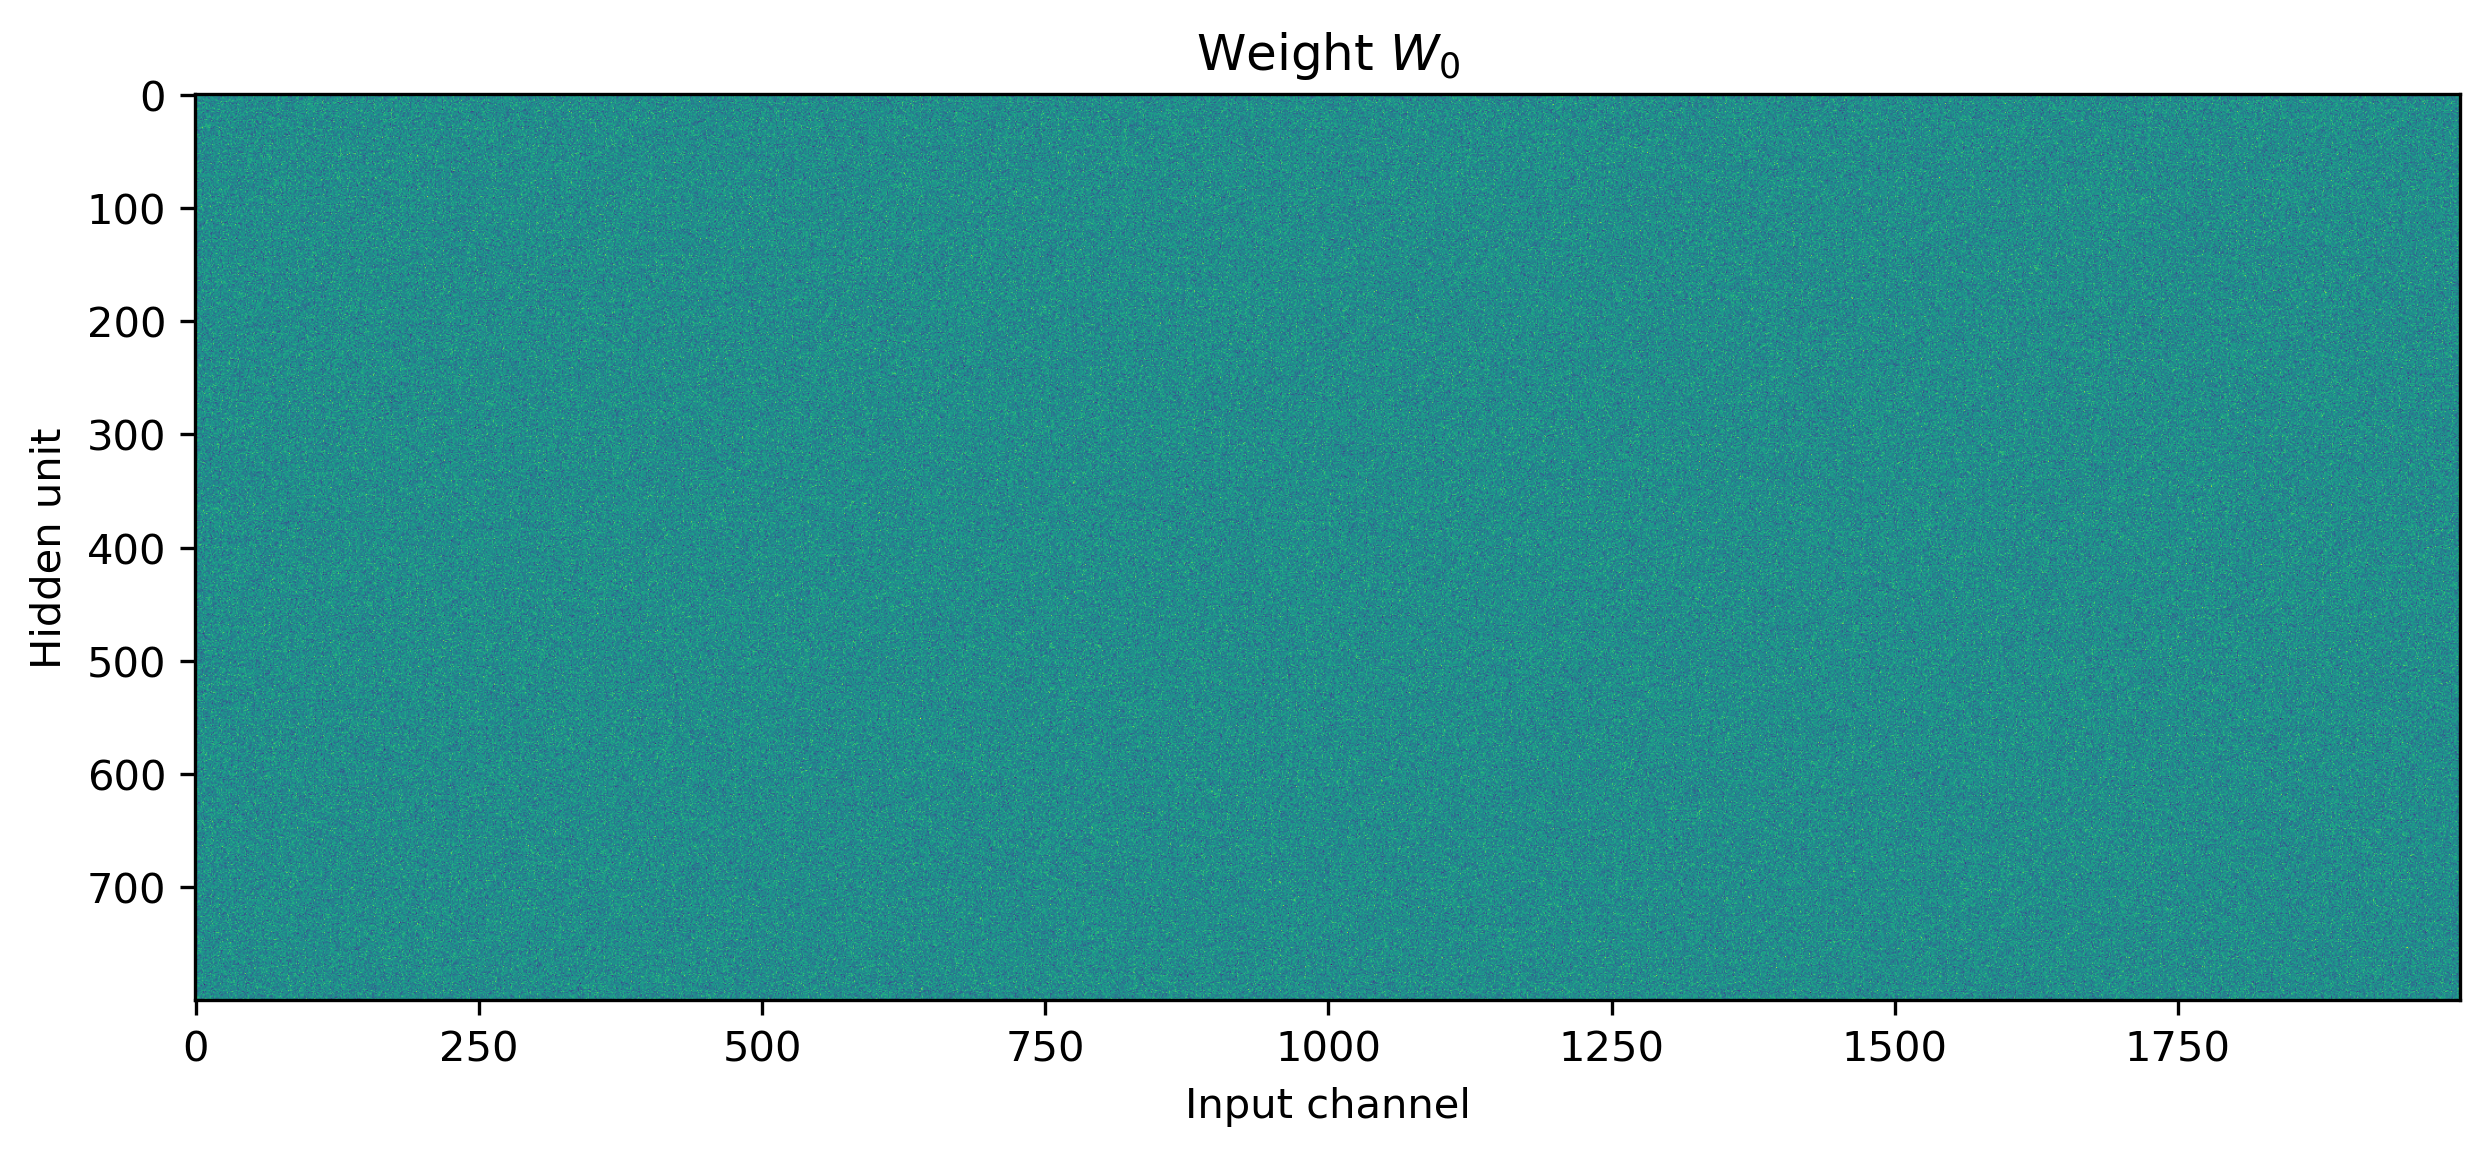

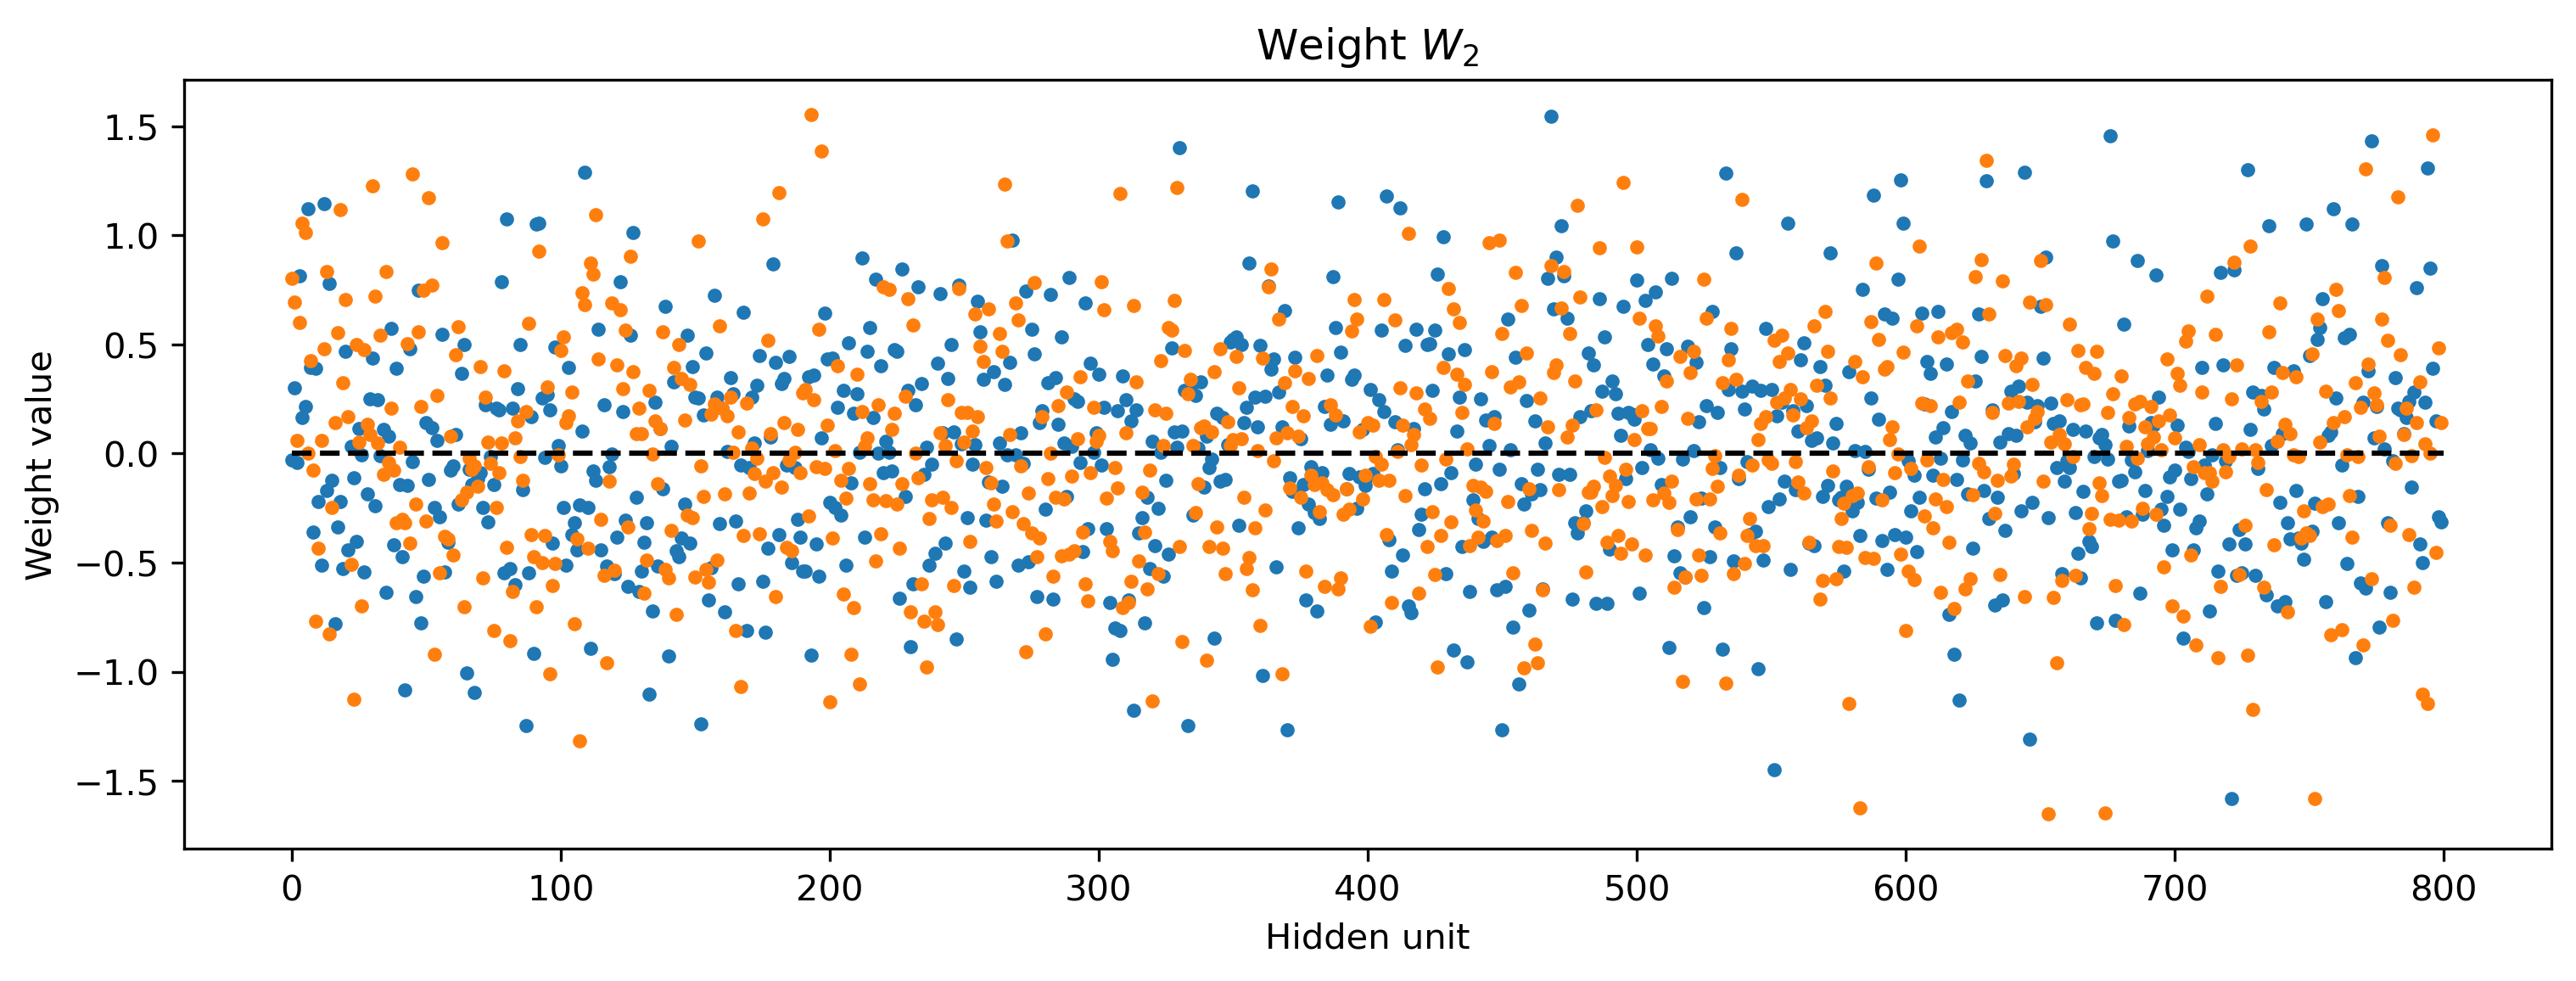

In [101]:
# - Display network parameters
plt.figure()
plt.imshow(net[0].weight.T)
plt.xlabel('Input channel')
plt.ylabel('Hidden unit')
plt.title('Weight $W_0$')

plt.figure()
plt.plot(net[2].weight, '.')
plt.plot([0, Nhidden], [0, 0], 'k--')
plt.xlabel('Hidden unit')
plt.ylabel('Weight value');
plt.title('Weight $W_2$');

# Advanced Jax training topics

## Providing bounds on parameters during optimisation

In [104]:
import jax.numpy as jnp

Nhidden = 200

net = Sequential(
    LinearJax((Nin, Nhidden)),
    RateEulerJax(Nhidden, activation_func = 'tanh'),
    LinearJax((Nhidden, Nout)),
)
print(net)

In [105]:
from rockpool.training.jax_loss import bounds_cost, make_bounds

# - Get a set of pre-configured bounds
min_bounds, max_bounds = make_bounds(net.parameters())
print('min_bounds: ', min_bounds,
      'max_bounds: ', max_bounds)

In [106]:
# - Configure the bounds for this network
min_bounds['1_RateEulerJax']['tau'] = 10e-3

In [107]:
def loss_mse_reg_bounds(grad_params, net, input, target):
    # - Handle the network state — randomise or reset
    net = net.reset_state()
    
    # - Assign the provided parameters to the network
    net = net.set_attributes(grad_params)
       
    # - Evolve the network to get the ouput
    output, _, _ = net(input)
    
    # - Compute a loss value w.r.t. the target output
    mse = l.mse(output, target)
    
    # - Add some parameter regularisation
    reg = l.l2sqr_norm(grad_params) * 1e3
    
    # - Impose the bounds
    bounds = bounds_cost(grad_params, min_bounds, max_bounds) * 1e3
    
    return mse + reg + bounds

## 